## Setup

In [1]:
# imports
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import os
import time

from kpca.utils import *
from kpca.kernel_pca import KernelPCA
from kpca.data import Loader, mnist

# ipython
%matplotlib inline 
%load_ext autoreload
%autoreload 2

# cuda
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

## Load Data

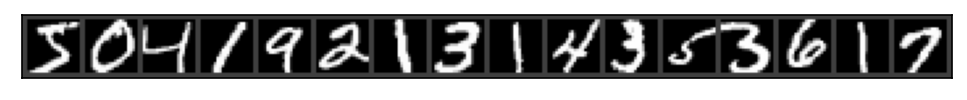

In [2]:
x1,l1,x2,l2,x3,l3 = mnist('cuda')[:6]
x = torch.cat([x1,x2,x3]) # concat train, val, test
x = x[:,:,4:-4,4:-4].contiguous() # crop borders
x = tovec(x) # convert to vec
x /= x.std() # normalize
show_grid(toim(x)[:16],nrow=16)

#### Load Networks

In [10]:
n = 800
lam = 1e-3

# alpha = 1
net1 = KernelPCA(m=400, n=n, alpha=1, lam=lam, eps=1e-3, device='cuda')
net1.load_state_dict(torch.load('../sep21/kernel-smatching-nets/n_800-alpha-1-v1-uncentered.pt'))
net1 = net1.cuda()

# alpha = 2
net2 = KernelPCA(m=400, n=n, alpha=2, lam=lam, eps=1e-3, device='cuda')
net2.load_state_dict(torch.load('../sep21/kernel-smatching-nets/n_800-alpha-2-v1-uncentered.pt'))
net2 = net2.cuda()

# alpha = 3
net3 = KernelPCA(m=400, n=n, alpha=3, lam=lam, eps=1e-3, device='cuda')
net3.load_state_dict(torch.load('../sep21/kernel-smatching-nets/n_800-alpha-3-v1-uncentered.pt'))
net3 = net3.cuda()

# alpha = 4
net4 = KernelPCA(m=400, n=n, alpha=4, lam=lam, eps=1e-3, device='cuda')
net4.load_state_dict(torch.load('../sep21/kernel-smatching-nets/n_800-alpha-4-v1-uncentered.pt'))
net4 = net4.cuda()

## Load Nets

In [22]:
# alpha = 1
net1 = KernelPCA(m=400, n=800, kernel='cos', d=1, lam=1e-3, device='cuda')
net1.load_state_dict(torch.load('./trained-nets/mnist-d_1.pt'))
net1 = net1.cuda()

# alpha = 2
net2 = KernelPCA(m=400, n=800, kernel='cos', d=2, lam=1e-3, device='cuda')
net2.load_state_dict(torch.load('./trained-nets/mnist-d_2.pt'))
net2 = net2.cuda()

# alpha = 3
net3 = KernelPCA(m=400, n=800, kernel='cos', d=3, lam=1e-3, device='cuda')
net3.load_state_dict(torch.load('./trained-nets/mnist-d_3.pt'))
net3 = net3.cuda()

# alpha = 4
net4 = KernelPCA(m=400, n=800, kernel='cos', d=4, lam=1e-3, device='cuda')
net4.load_state_dict(torch.load('./trained-nets/mnist-d_4.pt'))
net4 = net4.cuda()

## Filters

In [9]:
def grid_(im):
    im = im[:32]
    im = im - tovec(im).min(dim=1)[0].view(-1,1,1,1)
    im = im / tovec(im).max(dim=1)[0].view(-1,1,1,1)
    im = make_grid(im,nrow=4,pad_value=.50).permute(1,2,0)

    return im

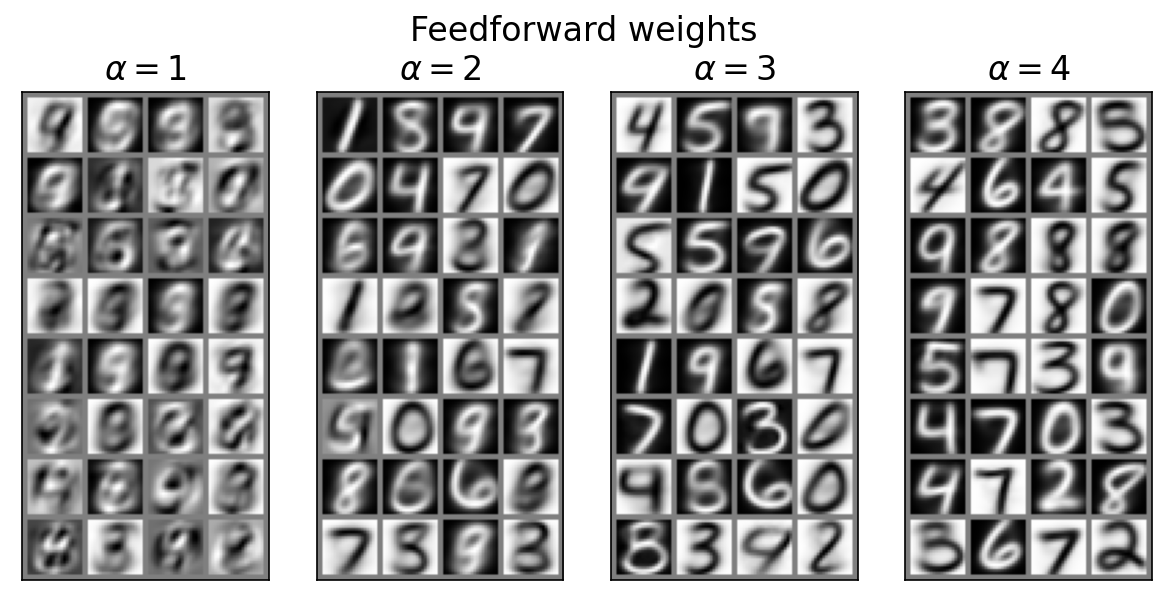

In [10]:
plt.figure(figsize=(8,4),dpi=150)
plt.suptitle('Feedforward weights',fontsize=16)

plt.subplot(141)
im = grid_(toim(net1.w.detach().cpu()))
plt.imshow(im)
plt.xticks([])
plt.yticks([])
plt.title(r'$\alpha=1$',fontsize=16)

plt.subplot(142)
im = grid_(toim(net2.w.detach().cpu()))
plt.imshow(im)
plt.xticks([])
plt.yticks([])
plt.title(r'$\alpha=2$',fontsize=16)

plt.subplot(143)
im = grid_(toim(net3.w.detach().cpu()))
plt.imshow(im)
plt.xticks([])
plt.yticks([])
plt.title(r'$\alpha=3$',fontsize=16)

plt.subplot(144)
im = grid_(toim(net4.w.detach().cpu()))
plt.imshow(im)
plt.xticks([])
plt.yticks([])
plt.title(r'$\alpha=4$',fontsize=16)

plt.tight_layout()

plt.savefig('./figures/mnist/feedforward-weights.pdf')
plt.show()

## Linearized Responses

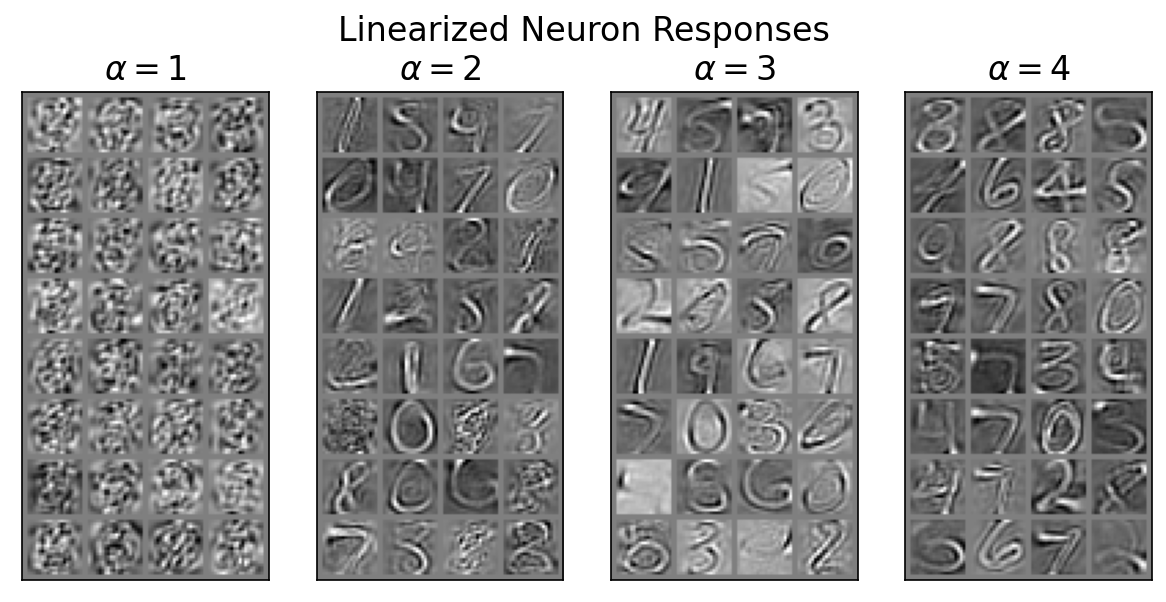

In [24]:
def grid_(im):
    im = im[:32]
    im = im - tovec(im).min(dim=1)[0].view(-1,1,1,1)
    im = im / tovec(im).max(dim=1)[0].view(-1,1,1,1)
    im = make_grid(im,nrow=4,pad_value=.50).permute(1,2,0)

    return im

plt.figure(figsize=(8,4),dpi=150)
plt.suptitle('Linearized Neuron Responses',fontsize=16)

plt.subplot(141)
im = grid_(toim(sta(x.cpu(),net1(x).cpu(),3e-1)))
plt.imshow(im)
plt.xticks([])
plt.yticks([])
plt.title(r'$\alpha=1$',fontsize=16)

plt.subplot(142)
im = grid_(toim(sta(x.cpu(),net2(x).cpu(),3e-1)))
plt.imshow(im)
plt.xticks([])
plt.yticks([])
plt.title(r'$\alpha=2$',fontsize=16)

plt.subplot(143)
im = grid_(toim(sta(x.cpu(),net3(x).cpu(),3e-1)))
plt.imshow(im)
plt.xticks([])
plt.yticks([])
plt.title(r'$\alpha=3$',fontsize=16)

plt.subplot(144)
im = grid_(toim(sta(x.cpu(),net4(x).cpu(),3e-1)))
plt.imshow(im)
plt.xticks([])
plt.yticks([])
plt.title(r'$\alpha=4$',fontsize=16)

plt.tight_layout()

plt.savefig('./figures/mnist/linearized-responses.pdf')
plt.show()

## Sparsity

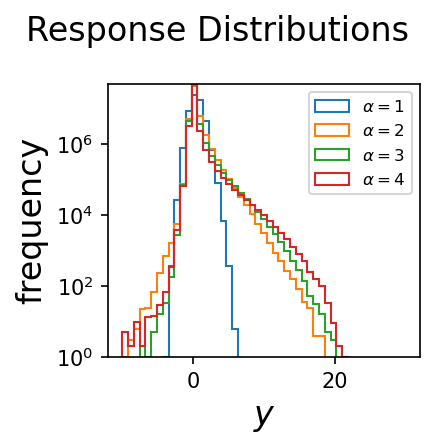

In [25]:
plt.figure(figsize=(3,3),dpi=150)
plt.suptitle('Response Distributions',fontsize=16)

bins = np.linspace(-10,30,50)
t = None

# net 1
y = net1(x)[:t]
y = y * y.mean(0).sign()
plt.hist(y.flatten().cpu().numpy(),bins=bins, histtype='step', label=r'$\alpha=1$')
plt.yscale('log')
plt.ylim(1e0,5e7)

# net 2
y = net2(x)[:t]
y = y * y.mean(0).sign()
plt.hist(y.flatten().cpu().numpy(),bins=bins, histtype='step', label=r'$\alpha=2$')
plt.yscale('log')
plt.ylim(1e0,5e7)[:t]

# net 3
y = net3(x)[:t]
y = y * y.mean(0).sign()
plt.hist(y.flatten().cpu().numpy(),bins=bins, histtype='step', label=r'$\alpha=3$')
plt.yscale('log')
plt.ylim(1e0,5e7)

# net 4 
y = net4(x)[:t]
y = y * y.mean(0).sign()
plt.hist(y.flatten().cpu().numpy(),bins=bins, histtype='step', label=r'$\alpha=4$')
plt.yscale('log')
plt.ylim(1e0,5e7)

plt.xlabel('$y$', fontsize=16)
plt.ylabel('frequency', fontsize=16)
plt.legend(fontsize=8)
plt.tight_layout()

plt.savefig('./figures/mnist/response-distributions.pdf')
plt.show()

## Similarities

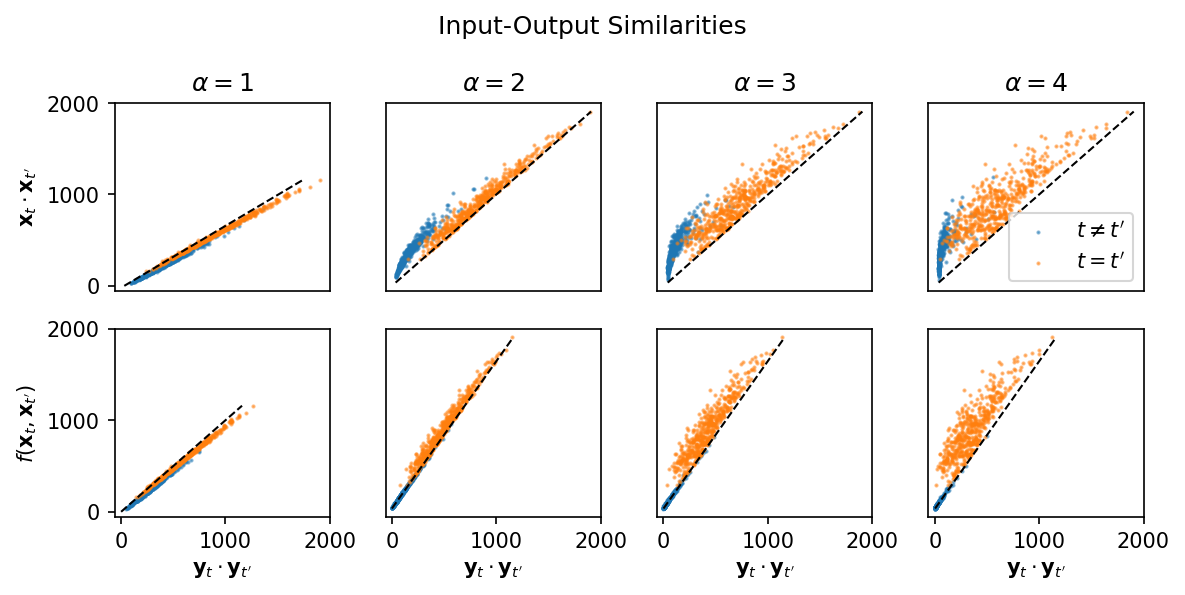

In [26]:
t = 512
xx = x[:t] @ x[:t].t()

plt.figure(figsize=(8,4),dpi=150)

###########
# alpha = 1
###########
y = net1(x)
yy = y[:t] @ y[:t].t()
fxx = net1.f(x[:t],x[:t])

plt.subplot(241)
ixs = torch.randperm(len(offdiag(xx)))[:t]
plt.scatter(offdiag(yy).detach().cpu().numpy()[ixs], offdiag(xx).detach().cpu().numpy()[ixs], s=1, alpha=0.5, label=r"$t \neq t'$")
plt.scatter(ondiag(yy).detach().cpu().numpy(), ondiag(xx).detach().cpu().numpy(), s=1, alpha=0.5, label="$t = t'$")
plt.plot(np.linspace(0,fxx.max().item()), np.linspace(0,fxx.max().item()), color='black', linewidth=1, linestyle='--')

plt.xticks([])
plt.yticks([0,1000,2000])
plt.ylabel("$\mathbf{x}_{t} \cdot \mathbf{x}_{t'}$")
plt.title(r'$\alpha=1$')

plt.subplot(245)
ixs = torch.randperm(len(offdiag(xx)))[:t]
plt.scatter(offdiag(yy).detach().cpu().numpy()[ixs], offdiag(fxx).detach().cpu().numpy()[ixs], s=1, alpha=0.5, label=r"$t \neq t'$")
plt.scatter(ondiag(yy).detach().cpu().numpy(), ondiag(fxx).detach().cpu().numpy(), s=1, label=r"$t = t'$", alpha=0.5)
plt.plot(np.linspace(0,fxx.max().item()), np.linspace(0,fxx.max().item()), color='black', linewidth=1, linestyle='--')

plt.xticks([0,1000,2000])
plt.yticks([0,1000,2000])
plt.xlabel("$\mathbf{y}_{t} \cdot \mathbf{y}_{t'}$")
plt.ylabel("$f(\mathbf{x}_{t},\mathbf{x}_{t'})$")

###########
# alpha = 2
###########
y = net2(x)
yy = y[:t] @ y[:t].t()
fxx = net2.f(x[:t],x[:t])

plt.subplot(242)
ixs = torch.randperm(len(offdiag(xx)))[:t]
plt.scatter(offdiag(yy).detach().cpu().numpy()[ixs], offdiag(xx).detach().cpu().numpy()[ixs], s=1, alpha=0.5, label=r"$t \neq t'$")
plt.scatter(ondiag(yy).detach().cpu().numpy(), ondiag(xx).detach().cpu().numpy(), s=1, alpha=0.5, label="$t = t'$")
plt.plot(np.linspace(0,fxx.max().item()), np.linspace(0,fxx.max().item()), color='black', linewidth=1, linestyle='--')

plt.xticks([])
plt.yticks([])
plt.title(r'$\alpha=2$')

plt.subplot(246)
ixs = torch.randperm(len(offdiag(xx)))[:t]
plt.scatter(offdiag(yy).detach().cpu().numpy()[ixs], offdiag(fxx).detach().cpu().numpy()[ixs], s=1, alpha=0.5, label=r"$t \neq t'$")
plt.scatter(ondiag(yy).detach().cpu().numpy(), ondiag(fxx).detach().cpu().numpy(), s=1, label=r"$t = t'$", alpha=0.5)
plt.plot(np.linspace(0,fxx.max().item()), np.linspace(0,fxx.max().item()), color='black', linewidth=1, linestyle='--')

plt.xticks([0,1000,2000])
plt.yticks([])
plt.xlabel("$\mathbf{y}_{t} \cdot \mathbf{y}_{t'}$")

###########
# alpha = 3
###########
y = net3(x)
yy = y[:t] @ y[:t].t()
fxx = net3.f(x[:t],x[:t])

plt.subplot(243)
ixs = torch.randperm(len(offdiag(xx)))[:t]
plt.scatter(offdiag(yy).detach().cpu().numpy()[ixs], offdiag(xx).detach().cpu().numpy()[ixs], s=1, alpha=0.5, label=r"$t \neq t'$")
plt.scatter(ondiag(yy).detach().cpu().numpy(), ondiag(xx).detach().cpu().numpy(), s=1, alpha=0.5, label="$t = t'$")
plt.plot(np.linspace(0,fxx.max().item()), np.linspace(0,fxx.max().item()), color='black', linewidth=1, linestyle='--')

plt.xticks([])
plt.yticks([])
plt.title(r'$\alpha=3$')

plt.subplot(247)
ixs = torch.randperm(len(offdiag(xx)))[:t]
plt.scatter(offdiag(yy).detach().cpu().numpy()[ixs], offdiag(fxx).detach().cpu().numpy()[ixs], s=1, alpha=0.5, label=r"$t \neq t'$")
plt.scatter(ondiag(yy).detach().cpu().numpy(), ondiag(fxx).detach().cpu().numpy(), s=1, label=r"$t = t'$", alpha=0.5)
plt.plot(np.linspace(0,fxx.max().item()), np.linspace(0,fxx.max().item()), color='black', linewidth=1, linestyle='--')

plt.xticks([0,1000,2000])
plt.yticks([])
plt.xlabel("$\mathbf{y}_{t} \cdot \mathbf{y}_{t'}$")

###########
# alpha = 4
###########
y = net4(x)
yy = y[:t] @ y[:t].t()
fxx = net4.f(x[:t],x[:t])

plt.subplot(244)
ixs = torch.randperm(len(offdiag(xx)))[:t]
plt.scatter(offdiag(yy).detach().cpu().numpy()[ixs], offdiag(xx).detach().cpu().numpy()[ixs], s=1, alpha=0.5, label=r"$t \neq t'$")
plt.scatter(ondiag(yy).detach().cpu().numpy(), ondiag(xx).detach().cpu().numpy(), s=1, alpha=0.5, label="$t = t'$")
plt.plot(np.linspace(0,fxx.max().item()), np.linspace(0,fxx.max().item()), color='black', linewidth=1, linestyle='--')

plt.xticks([])
plt.yticks([])
plt.title(r'$\alpha=4$')
plt.legend()

plt.subplot(248)
ixs = torch.randperm(len(offdiag(xx)))[:t]
plt.scatter(offdiag(yy).detach().cpu().numpy()[ixs], offdiag(fxx).detach().cpu().numpy()[ixs], s=1, alpha=0.5, label=r"$t \neq t'$")
plt.scatter(ondiag(yy).detach().cpu().numpy(), ondiag(fxx).detach().cpu().numpy(), s=1, label=r"$t = t'$", alpha=0.5)
plt.plot(np.linspace(0,fxx.max().item()), np.linspace(0,fxx.max().item()), color='black', linewidth=1, linestyle='--')

plt.xticks([0,1000,2000])
plt.yticks([])
plt.xlabel("$\mathbf{y}_{t} \cdot \mathbf{y}_{t'}$")

plt.suptitle('Input-Output Similarities')
plt.tight_layout()

plt.savefig('./figures/mnist/input-output-similarities.pdf')
plt.show()

## Eigenvalue Alignment

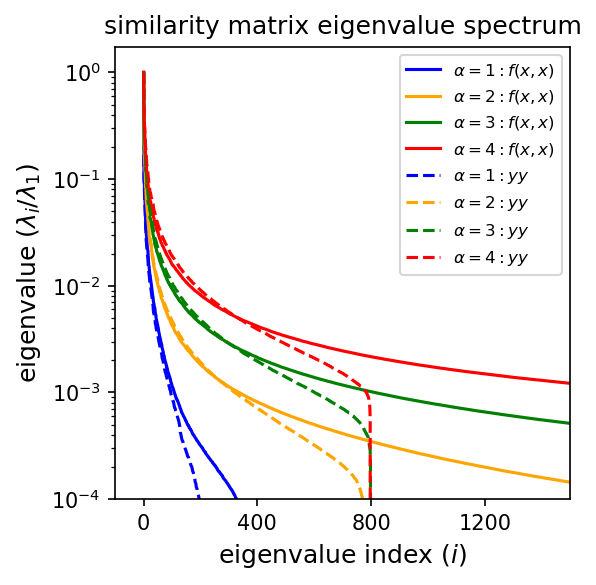

In [27]:
plt.figure(figsize=(4,4),dpi=150)

t = 10000
#######
# fxx #
#######
lff = net1.f(x[:t],x[:t]).symeig()[0].cpu()
plt.plot((lff.flip(0) / lff[-1]), label=r'$\alpha=1 : f(x,x)$', color='blue', linestyle='-')

lff = net2.f(x[:t],x[:t]).symeig()[0].cpu()
plt.plot((lff.flip(0) / lff[-1]), label=r'$\alpha=2 : f(x,x)$', color='orange', linestyle='-')

lff = net3.f(x[:t],x[:t]).symeig()[0].cpu()
plt.plot((lff.flip(0) / lff[-1]), label=r'$\alpha=3 : f(x,x)$', color='green', linestyle='-')

lff = net4.f(x[:t],x[:t]).symeig()[0].cpu()
plt.plot((lff.flip(0) / lff[-1]), label=r'$\alpha=4 : f(x,x)$', color='red', linestyle='-')

#######
# yy  #
#######
lyy = cor_mat(net1(x[:t]),net1(x[:t])).symeig()[0].detach().cpu()
plt.plot((lyy.flip(0) / lyy[-1]), label=r'$\alpha=1 : yy$', color='blue', linestyle='--')

lyy = cor_mat(net2(x[:t]),net2(x[:t])).symeig()[0].detach().cpu()
plt.plot((lyy.flip(0) / lyy[-1]), label=r'$\alpha=2 : yy$', color='orange', linestyle='--')

lyy = cor_mat(net3(x[:t]),net3(x[:t])).symeig()[0].detach().cpu()
plt.plot((lyy.flip(0) / lyy[-1]), label=r'$\alpha=3 : yy$', color='green', linestyle='--')

lyy = cor_mat(net4(x[:t]),net4(x[:t])).symeig()[0].detach().cpu()
plt.plot((lyy.flip(0) / lyy[-1]), label=r'$\alpha=4 : yy$', color='red', linestyle='--')

plt.yscale('log')
plt.ylim(1e-4,1.75)
plt.ylabel('eigenvalue ($\lambda_i / \lambda_1$)', fontsize=12)

plt.xlabel('eigenvalue index $(i)$', fontsize=12)
plt.xlim(-100,1500)
plt.xticks([0,400,800,1200])

plt.legend(fontsize=8)
              
plt.title('similarity matrix eigenvalue spectrum',fontsize=12)

plt.tight_layout()
plt.savefig('./figures/mnist/eigenvalues.pdf')
plt.show()

# Old Stuff

## Supervised Evaluation

#### Euclidean

In [17]:
from hcgame.classifiers import LogisticRegressionClassifier, NearestNeighborClassifier, accuracy_curve

def evaluate(u,u_,y,y_,seeds,ks):
    scores = {}
    for seed in seeds:
        for k in ks:
            # set seed
            torch.random.manual_seed(seed)

            # select data
            ut = torch.zeros(k*10,u.shape[1],dtype=u.dtype, device=u.device)
            yt = torch.zeros(k*10,dtype=y.dtype, device=y.device)
            for i in range(10):
                ixs = torch.where(y==i)[0]
                ixs = ixs[torch.randperm(len(ixs))[:k]]

                ut[i*k:(i+1)*k] = u[ixs].clone()
                yt[i*k:(i+1)*k] = y[ixs].clone()

            # train classifier
            clf = NearestNeighborClassifier('euclidean', 1)
            clf.train(ut,yt)
            s_trn,s_val = None, clf.score(u_,y_)

            # log result
            scores[seed,k] = (s_trn,s_val)
            print('seed: {}, k: {}, s_trn: {}, s_val: {}'.format(seed, k, s_trn, s_val))

    return scores

In [18]:
device = 'cpu'
seeds = [0]
ks = [1,3,10,30,100,300,1000,3000]

xscores_euc = evaluate(x.to(device), x_.to(device), labels.to(device), labels_.to(device),seeds,ks)
y1scores_euc = evaluate(net1(x).to(device), net1(x_).to(device), labels.to(device), labels_.to(device),seeds,ks)
y2scores_euc = evaluate(net2(x).to(device), net2(x_).to(device), labels.to(device), labels_.to(device),seeds,ks)
y3scores_euc = evaluate(net3(x).to(device), net3(x_).to(device), labels.to(device), labels_.to(device),seeds,ks)
y4scores_euc = evaluate(net4(x).to(device), net4(x_).to(device), labels.to(device), labels_.to(device),seeds,ks)

seed: 0, k: 1, s_trn: None, s_val: 0.41940000653266907
seed: 0, k: 3, s_trn: None, s_val: 0.5763000249862671
seed: 0, k: 10, s_trn: None, s_val: 0.7197999954223633
seed: 0, k: 30, s_trn: None, s_val: 0.82669997215271
seed: 0, k: 100, s_trn: None, s_val: 0.8862000107765198
seed: 0, k: 300, s_trn: None, s_val: 0.9291999936103821
seed: 0, k: 1000, s_trn: None, s_val: 0.9526000022888184
seed: 0, k: 3000, s_trn: None, s_val: 0.9659000039100647
seed: 0, k: 1, s_trn: None, s_val: 0.4228000044822693
seed: 0, k: 3, s_trn: None, s_val: 0.5806999802589417
seed: 0, k: 10, s_trn: None, s_val: 0.7271999716758728
seed: 0, k: 30, s_trn: None, s_val: 0.8331000208854675
seed: 0, k: 100, s_trn: None, s_val: 0.8888000249862671
seed: 0, k: 300, s_trn: None, s_val: 0.9322999715805054
seed: 0, k: 1000, s_trn: None, s_val: 0.954800009727478
seed: 0, k: 3000, s_trn: None, s_val: 0.9670000076293945
seed: 0, k: 1, s_trn: None, s_val: 0.3612000048160553
seed: 0, k: 3, s_trn: None, s_val: 0.5430999994277954
seed: 

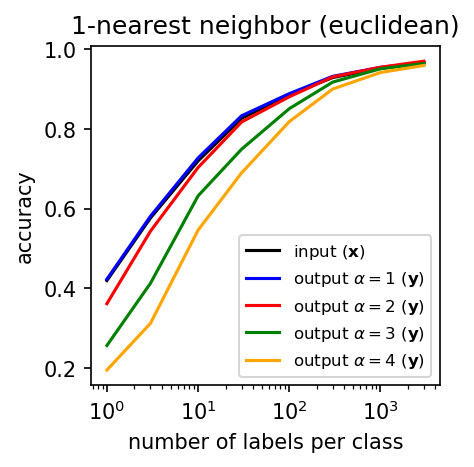

In [19]:
plt.figure(figsize=(3, 3), dpi=150)

plt.plot(ks, [sum([xscores_euc[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='black', label=r'input ($\mathbf{x}$)')
plt.plot(ks, [sum([y1scores_euc[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='blue', label=r'output $\alpha=1$ ($\mathbf{y}$)')
plt.plot(ks, [sum([y2scores_euc[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='red', label=r'output $\alpha=2$ ($\mathbf{y}$)')
plt.plot(ks, [sum([y3scores_euc[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='green', label=r'output $\alpha=3$ ($\mathbf{y}$)')
plt.plot(ks, [sum([y4scores_euc[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='orange', label=r'output $\alpha=4$ ($\mathbf{y}$)')

plt.legend(fontsize=8)
plt.xscale('log')

plt.xlabel('number of labels per class')
plt.ylabel('accuracy')
plt.title('1-nearest neighbor (euclidean)')
plt.show()

#### Cosine

In [20]:
from hcgame.classifiers import LogisticRegressionClassifier, NearestNeighborClassifier, accuracy_curve

def evaluate(u,u_,y,y_,seeds,ks):
    scores = {}
    for seed in seeds:
        for k in ks:
            # set seed
            torch.random.manual_seed(seed)

            # select data
            ut = torch.zeros(k*10,u.shape[1],dtype=u.dtype, device=u.device)
            yt = torch.zeros(k*10,dtype=y.dtype, device=y.device)
            for i in range(10):
                ixs = torch.where(y==i)[0]
                ixs = ixs[torch.randperm(len(ixs))[:k]]

                ut[i*k:(i+1)*k] = u[ixs].clone()
                yt[i*k:(i+1)*k] = y[ixs].clone()

            # train classifier
            clf = NearestNeighborClassifier('cosine', 1)
            clf.train(ut,yt)
            s_trn,s_val = None, clf.score(u_,y_)

            # log result
            scores[seed,k] = (s_trn,s_val)
            print('seed: {}, k: {}, s_trn: {}, s_val: {}'.format(seed, k, s_trn, s_val))

    return scores

In [21]:
device = 'cpu'
seeds = [0]
ks = [1,3,10,30,100,300,1000,3000]

xscores_cos = evaluate(x.to(device), x_.to(device), labels.to(device), labels_.to(device),seeds,ks)
y1scores_cos = evaluate(net1(x).to(device), net1(x_).to(device), labels.to(device), labels_.to(device),seeds,ks)
y2scores_cos = evaluate(net2(x).to(device), net2(x_).to(device), labels.to(device), labels_.to(device),seeds,ks)
y3scores_cos = evaluate(net3(x).to(device), net3(x_).to(device), labels.to(device), labels_.to(device),seeds,ks)
y4scores_cos = evaluate(net4(x).to(device), net4(x_).to(device), labels.to(device), labels_.to(device),seeds,ks)

seed: 0, k: 1, s_trn: None, s_val: 0.43709999322891235
seed: 0, k: 3, s_trn: None, s_val: 0.597000002861023
seed: 0, k: 10, s_trn: None, s_val: 0.7484999895095825
seed: 0, k: 30, s_trn: None, s_val: 0.8528000116348267
seed: 0, k: 100, s_trn: None, s_val: 0.9053999781608582
seed: 0, k: 300, s_trn: None, s_val: 0.9381999969482422
seed: 0, k: 1000, s_trn: None, s_val: 0.9588000178337097
seed: 0, k: 3000, s_trn: None, s_val: 0.9714999794960022
seed: 0, k: 1, s_trn: None, s_val: 0.4399000108242035
seed: 0, k: 3, s_trn: None, s_val: 0.602400004863739
seed: 0, k: 10, s_trn: None, s_val: 0.7530999779701233
seed: 0, k: 30, s_trn: None, s_val: 0.8561000227928162
seed: 0, k: 100, s_trn: None, s_val: 0.9078999757766724
seed: 0, k: 300, s_trn: None, s_val: 0.9401000142097473
seed: 0, k: 1000, s_trn: None, s_val: 0.9595000147819519
seed: 0, k: 3000, s_trn: None, s_val: 0.9735000133514404
seed: 0, k: 1, s_trn: None, s_val: 0.4408000111579895
seed: 0, k: 3, s_trn: None, s_val: 0.6036999821662903
seed:

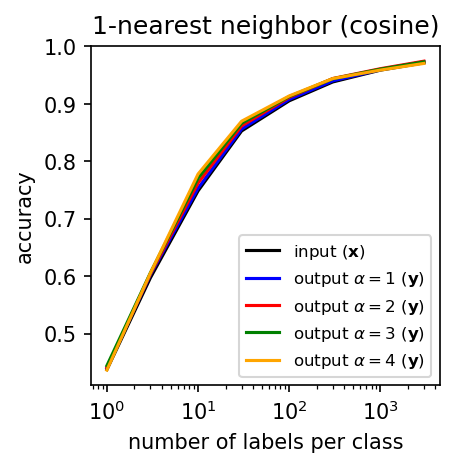

In [22]:
plt.figure(figsize=(3, 3), dpi=150)

plt.plot(ks, [sum([xscores_cos[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='black', label=r'input ($\mathbf{x}$)')
plt.plot(ks, [sum([y1scores_cos[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='blue', label=r'output $\alpha=1$ ($\mathbf{y}$)')
plt.plot(ks, [sum([y2scores_cos[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='red', label=r'output $\alpha=2$ ($\mathbf{y}$)')
plt.plot(ks, [sum([y3scores_cos[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='green', label=r'output $\alpha=3$ ($\mathbf{y}$)')
plt.plot(ks, [sum([y4scores_cos[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='orange', label=r'output $\alpha=4$ ($\mathbf{y}$)')

plt.legend(fontsize=8)
plt.xscale('log')

plt.xlabel('number of labels per class')
plt.ylabel('accuracy')
plt.title('1-nearest neighbor (cosine)')
plt.show()

#### Linear

In [23]:
from hcgame.classifiers import LogisticRegressionClassifier, accuracy_curve

def evaluate(u,u_,y,y_,seeds,ks,lams):
    scores = {}
    for seed in seeds:
        for k in ks:
            for lam in lams:
                # set seed
                torch.random.manual_seed(seed)

                # select data
                ut = torch.zeros(k*10,u.shape[1],dtype=u.dtype, device=u.device)
                yt = torch.zeros(k*10,dtype=y.dtype, device=y.device)
                for i in range(10):
                    ixs = torch.where(y==i)[0]
                    ixs = ixs[torch.randperm(len(ixs))[:k]]

                    ut[i*k:(i+1)*k] = u[ixs].clone()
                    yt[i*k:(i+1)*k] = y[ixs].clone()

                # train classifier
                clf = LogisticRegressionClassifier(u.shape[1],10,lam).to(u.device)
                clf.train(ut,yt)
                s_trn,s_val = clf.score(ut,yt), clf.score(u_,y_)

                # log result
                improved = s_val > scores.get((seed,k),(0,0,None))[1]
                if improved:
                    scores[seed,k] = (s_trn,s_val,lam)
                print('seed: {}, k: {}, lam: {}, s_trn: {}, s_val: {}, improved: {}'.format(seed, k, lam, s_trn, s_val, improved))

    return scores

In [24]:
device = 'cpu'
seeds = [0]
ks = [1,3,10,30,100,300,1000,3000]
lams = [1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1]

# def normalize(x):
#     return (x-x.mean(0)) / x.std()

# xh = normalize(net.x)
# yh = normalize(net.y)

xscores_lin = evaluate(x.to(device), x_.to(device), labels.to(device), labels_.to(device),seeds,ks,lams)
y1scores_lin = evaluate(net1(x).to(device), net1(x_).to(device), labels.to(device), labels_.to(device),seeds,ks,lams)
y2scores_lin = evaluate(net2(x).to(device), net2(x_).to(device), labels.to(device), labels_.to(device),seeds,ks,lams)
y3scores_lin = evaluate(net3(x).to(device), net3(x_).to(device), labels.to(device), labels_.to(device),seeds,ks,lams)
y4scores_lin = evaluate(net4(x).to(device), net4(x_).to(device), labels.to(device), labels_.to(device),seeds,ks,lams)


seed: 0, k: 1, lam: 1e-05, s_trn: 1.0, s_val: 0.4603999853134155, improved: True
seed: 0, k: 1, lam: 0.0001, s_trn: 1.0, s_val: 0.4602999985218048, improved: False
seed: 0, k: 1, lam: 0.001, s_trn: 1.0, s_val: 0.45910000801086426, improved: False
seed: 0, k: 1, lam: 0.01, s_trn: 1.0, s_val: 0.4577000141143799, improved: False
seed: 0, k: 1, lam: 0.1, s_trn: 1.0, s_val: 0.4562000036239624, improved: False
seed: 0, k: 1, lam: 1.0, s_trn: 1.0, s_val: 0.453000009059906, improved: False
seed: 0, k: 1, lam: 10.0, s_trn: 1.0, s_val: 0.4401000142097473, improved: False
seed: 0, k: 3, lam: 1e-05, s_trn: 1.0, s_val: 0.6298999786376953, improved: True
seed: 0, k: 3, lam: 0.0001, s_trn: 1.0, s_val: 0.6301000118255615, improved: True
seed: 0, k: 3, lam: 0.001, s_trn: 1.0, s_val: 0.6305000185966492, improved: True
seed: 0, k: 3, lam: 0.01, s_trn: 1.0, s_val: 0.631600022315979, improved: True
seed: 0, k: 3, lam: 0.1, s_trn: 1.0, s_val: 0.6315000057220459, improved: False
seed: 0, k: 3, lam: 1.0, s_tr

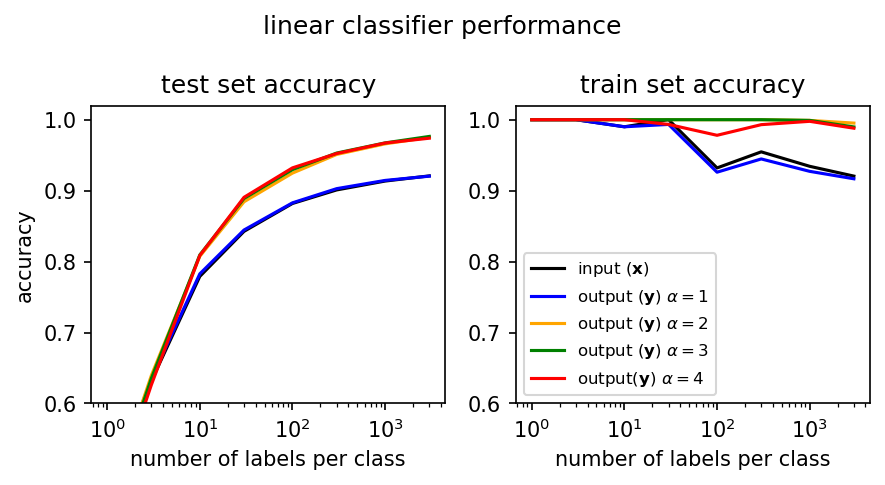

In [25]:
plt.figure(figsize=(6, 3.25), dpi=150)
plt.subplot(121)
plt.plot(ks, [sum([xscores_lin[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='black', label=r'input ($\mathbf{x}$)')
plt.plot(ks, [sum([y1scores_lin[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='blue', label=r'output ($\mathbf{y}$) $\alpha=1$')
plt.plot(ks, [sum([y2scores_lin[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='orange', label=r'output ($\mathbf{y}$) $\alpha=2$')
plt.plot(ks, [sum([y3scores_lin[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='green', label=r'output ($\mathbf{y}$) $\alpha=3$')
plt.plot(ks, [sum([y4scores_lin[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='red', label=r'output ($\mathbf{y}$) $\alpha=4$')

plt.xscale('log')

plt.xlabel('number of labels per class')
plt.ylabel('accuracy')
plt.title('test set accuracy')

plt.ylim(0.6,1.02)

plt.subplot(122)
plt.plot(ks, [sum([xscores_lin[seed,k][0] for seed in seeds])/len(seeds) for k in ks], color='black', label=r'input ($\mathbf{x}$)')
plt.plot(ks, [sum([y1scores_lin[seed,k][0] for seed in seeds])/len(seeds) for k in ks], color='blue', label=r'output ($\mathbf{y}$) $\alpha=1$')
plt.plot(ks, [sum([y2scores_lin[seed,k][0] for seed in seeds])/len(seeds) for k in ks], color='orange', label=r'output ($\mathbf{y}$) $\alpha=2$')
plt.plot(ks, [sum([y3scores_lin[seed,k][0] for seed in seeds])/len(seeds) for k in ks], color='green', label=r'output ($\mathbf{y}$) $\alpha=3$')
plt.plot(ks, [sum([y4scores_lin[seed,k][0] for seed in seeds])/len(seeds) for k in ks], color='red', label=r'output($\mathbf{y}$) $\alpha=4$')

plt.xscale('log')
plt.xlabel('number of labels per class')
plt.title('train set accuracy')
plt.legend(fontsize=8)

plt.ylim(0.6,1.02)

plt.suptitle('linear classifier performance')
plt.tight_layout()

plt.savefig('./kernel-smatching-figures-uncentered/linear-classifier.pdf')
plt.show()

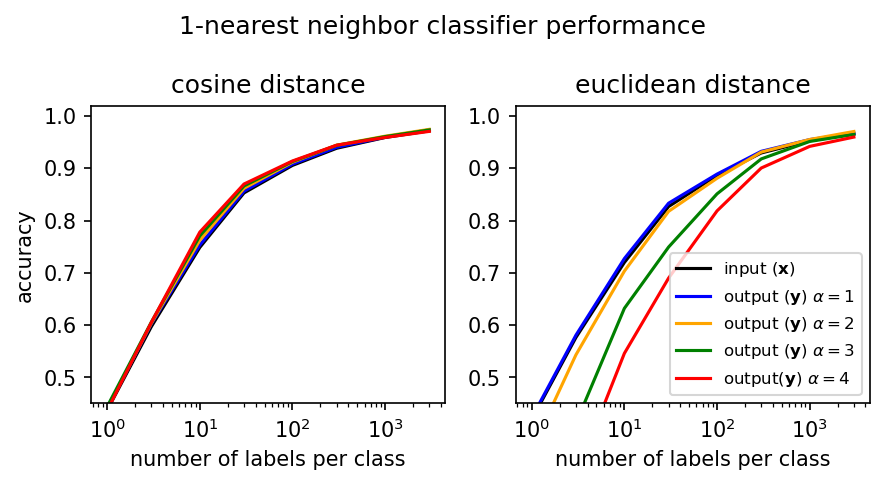

In [26]:
plt.figure(figsize=(6, 3.25), dpi=150)
plt.subplot(121)
plt.plot(ks, [sum([xscores_cos[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='black', label=r'input ($\mathbf{x}$)')
plt.plot(ks, [sum([y1scores_cos[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='blue', label=r'output ($\mathbf{y}$) $\alpha=1$')
plt.plot(ks, [sum([y2scores_cos[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='orange', label=r'output ($\mathbf{y}$) $\alpha=2$')
plt.plot(ks, [sum([y3scores_cos[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='green', label=r'output ($\mathbf{y}$) $\alpha=3$')
plt.plot(ks, [sum([y4scores_cos[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='red', label=r'output ($\mathbf{y}$) $\alpha=4$')

plt.xscale('log')

plt.xlabel('number of labels per class')
plt.ylabel('accuracy')
plt.title('cosine distance')

plt.ylim(0.45,1.02)

plt.subplot(122)
plt.plot(ks, [sum([xscores_euc[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='black', label=r'input ($\mathbf{x}$)')
plt.plot(ks, [sum([y1scores_euc[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='blue', label=r'output ($\mathbf{y}$) $\alpha=1$')
plt.plot(ks, [sum([y2scores_euc[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='orange', label=r'output ($\mathbf{y}$) $\alpha=2$')
plt.plot(ks, [sum([y3scores_euc[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='green', label=r'output ($\mathbf{y}$) $\alpha=3$')
plt.plot(ks, [sum([y4scores_euc[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='red', label=r'output($\mathbf{y}$) $\alpha=4$')

plt.xscale('log')
plt.xlabel('number of labels per class')
plt.title('euclidean distance')
plt.legend(fontsize=8)

plt.ylim(0.45,1.02)

plt.suptitle('1-nearest neighbor classifier performance')
plt.tight_layout()

plt.savefig('./kernel-smatching-figures-uncentered/nearest-neighbor.pdf')
plt.show()